In [1]:
from tika import parser
import re
import spacy
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
nlp = spacy.load('en_core_web_sm')

In [4]:
thesis_list = []
for i in range (1,61):
    file = 'thesis/thesis ({}).pdf'.format(i)
    file_data = parser.from_file(file)
    if len(str(file_data['content'])) > 500000:
        thesis_list.append(str(file_data['content'][10000:500000]))
    else:
        thesis_list.append(str(file_data['content'])[10000:-10000])

In [5]:
thesis = [nlp(thes) for thes in thesis_list[:30]]

In [6]:
thesis2 = [nlp(thes) for thes in thesis_list[30:]]

In [7]:
thesis3 = thesis + thesis2

In [8]:
def partOfSpeech(nlp_list):
    tokens = [Counter([token.pos_ for token in doc if not (token.is_space | token.is_punct)]) for doc in nlp_list]
    sentences = [len(list(doc.sents)) for doc in nlp_list]
    return tokens, sentences

In [9]:
def posToDataframe(tokens, sentences, genre):
    df = pd.DataFrame(tokens) \
        .fillna(0)
    df = df.div(df.sum(axis=1), axis=0) \
        .applymap('{:,.2f}'.format) \
        .astype(float)
    new_names = {'ADJ':'adjective', 'ADP':'adposition', 'ADV':'adverb', 'AUX':'auxiliary', 'CONJ':'conjunction', 
              'CCONJ':'coordinating_conjunction', 'DET':'determiner', 'INTJ':'interjection', 'NOUN':'noun', 
              'NUM':'numeral', 'PART':'particle', 'PRON':'pronoun', 'PROPN':'proper_noun', 'PUNCT':'punctuation', 
              'SCONJ':'subordinating_conjunction', 'SYM':'symbol', 'VERB':'verb', 'X':'other', 'SPACE':'space'}
    df = df.rename(columns=new_names) 
    df['sentences'] = sentences
    df['genre'] = [genre for x in range(0, len(df))]
    return df

In [10]:
def histFromDataframe(df):
    fig = plt.figure(figsize=(18,16))
    i, j = 1, 0
    for column in df.columns:
        fig.add_subplot(4,5,i)
        plt.hist(df[column])
        plt.title(column)
        i+=1
    return plt.show()

In [142]:
def convertToNum(string):
    if string == 'news': return 0
    else: return 1

In [11]:
tokens, sentences = partOfSpeech(thesis3)

In [12]:
thesis_df = posToDataframe(tokens, sentences, 'thesis')

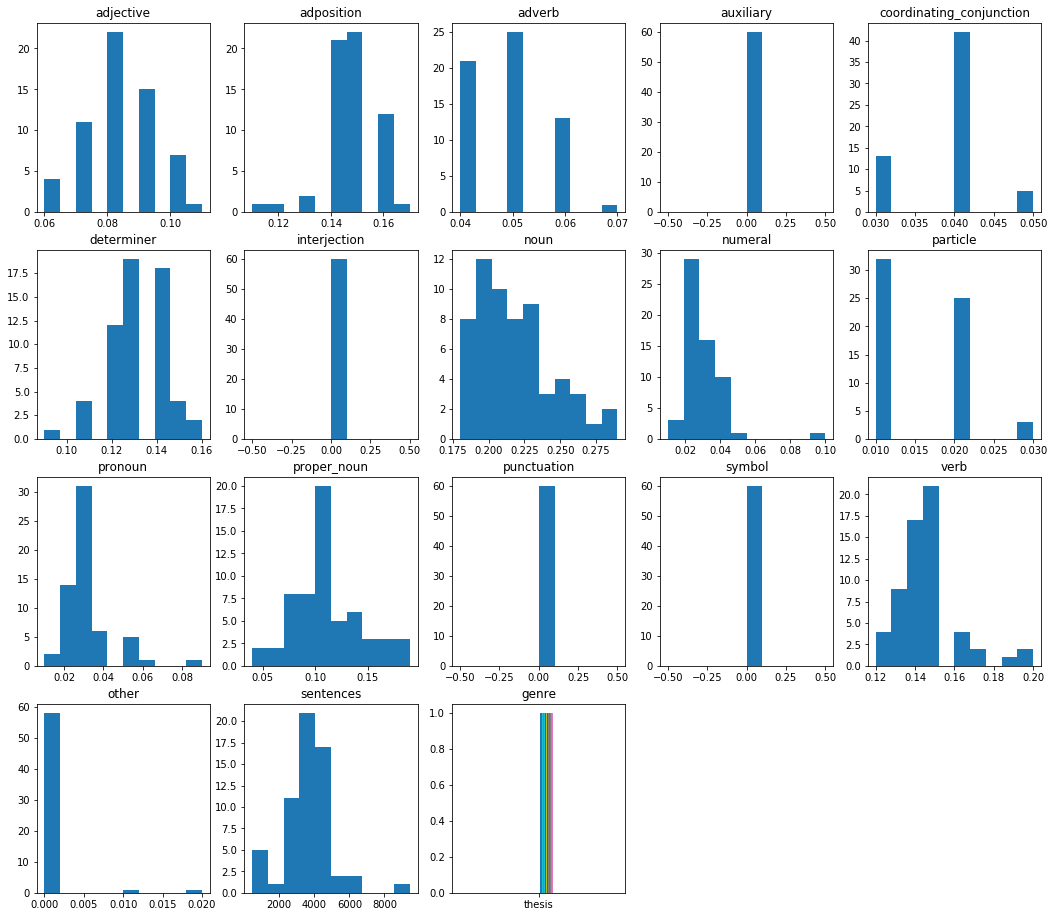

In [13]:
histFromDataframe(thesis_df)

In [14]:
path = 'articles1.csv'
temp_news = pd.read_csv(path)

In [15]:
news = [nlp(new) for new in temp_news['content'][:500]]

In [16]:
tokens, sentences = partOfSpeech(news)

In [17]:
news_df = posToDataframe(tokens, sentences, 'news')

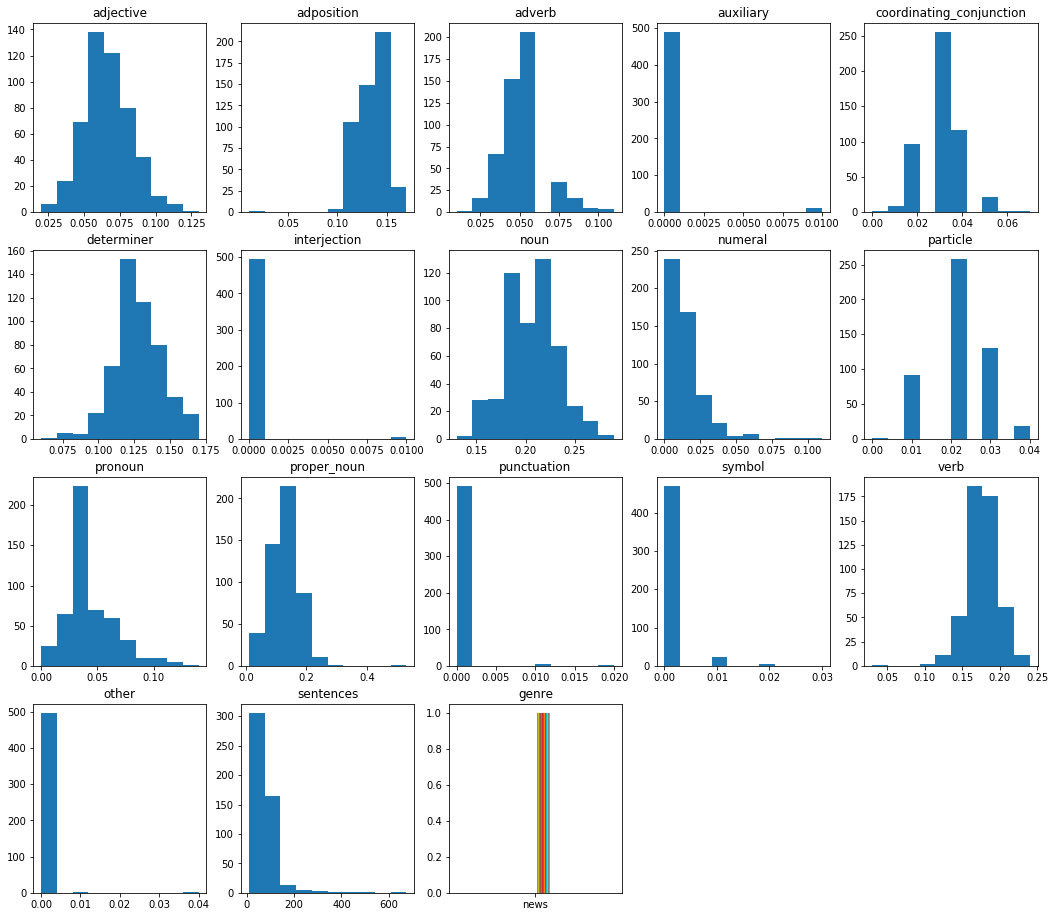

In [18]:
histFromDataframe(news_df)

In [364]:
final = news_df.sample(100).append(thesis_df)
final['genre'] = final['genre'].apply(convertToNum)
final = final*100
final['genre'] = (final['genre']/100).astype(int)

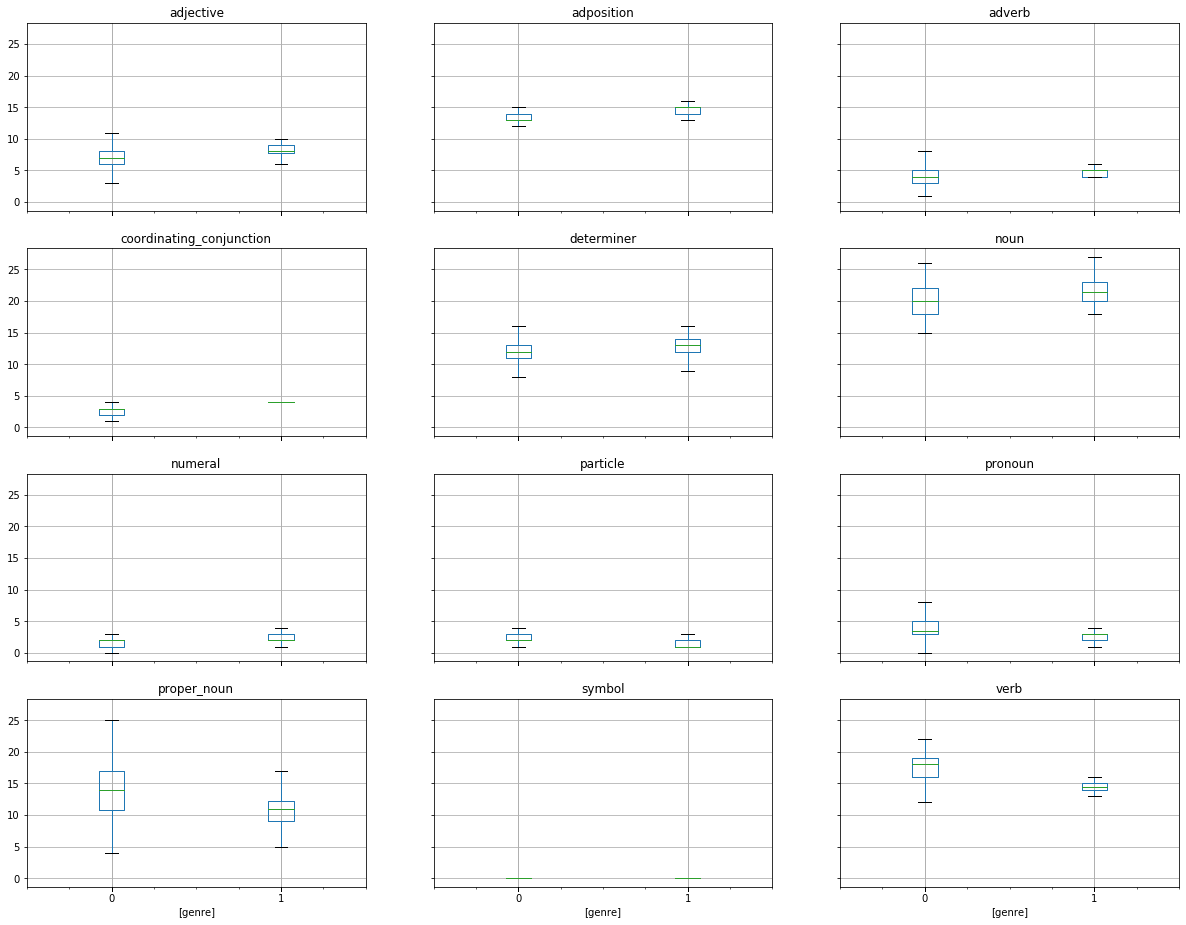

In [365]:
drop_list = final.drop('genre', axis=1).columns[(final.drop('genre', axis=1).mean()<=0.02) | (final.drop('genre', axis=1).mean()>=100)]
drop_list = drop_list.tolist()
final.drop(drop_list, axis=1).boxplot(by='genre', showfliers=False, figsize=(20,16))
plt.suptitle('')
plt.show()

In [407]:
features = final.columns.tolist()

y = ['genre']
X = [i for i in data_final_vars if (i not in y) & (i != 'sentences')]

X_fit = final[X]
y_fit = final[y]

logreg = LogisticRegression(solver='lbfgs', max_iter=300)

rfe = RFE(logreg, 10)
rfe = rfe.fit(X_bla, y_bla.values.ravel())

In [408]:
cols = X_fit.columns[rfe.support_]

In [409]:
X = X_fit[cols]
y = y_fit['genre']

In [410]:
logit_model = sm.Logit(y, X)
result = logit_model.fit(maxiter=100, method='lbfgs')
print(result.summary2())

                                        Results: Logit
Model:                         Logit                     Pseudo R-squared:          0.812     
Dependent Variable:            genre                     AIC:                       57.7529   
Date:                          2020-03-24 02:12          BIC:                       85.4295   
No. Observations:              160                       Log-Likelihood:            -19.876   
Df Model:                      8                         LL-Null:                   -105.85   
Df Residuals:                  151                       LLR p-value:               5.0385e-33
Converged:                     1.0000                    Scale:                     1.0000    
No. Iterations:                80.0000                                                        
----------------------------------------------------------------------------------------------
                          Coef.      Std.Err.       z    P>|z|       [0.025         0.975]

In [427]:
relevant_features = result.pvalues.loc[result.pvalues<=0.05]
cols = relevant_features.index.tolist()
X = X_fit[cols]

In [428]:
logit_model = sm.Logit(y, X)
result = logit_model.fit(maxiter=100, method='lbfgs')
print(result.summary2())

                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.681     
Dependent Variable:    genre              AIC:                79.4896   
Date:                  2020-03-24 02:16   BIC:                97.9407   
No. Observations:      160                Log-Likelihood:     -33.745   
Df Model:              5                  LL-Null:            -105.85   
Df Residuals:          154                LLR p-value:        2.2771e-29
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        25.0000                                          
------------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------
adposition                0.8337   0.2019  4.1298 0.0000  0.4380  1.2293
coordinating_conjunction  2.2100   0.5213  4.2389 0.0000  1.1881  3.2318
numeral

In [429]:
relevant_features = result.pvalues.loc[result.pvalues<=0.05]
cols = relevant_features.index.tolist()
X = X_fit[cols]

In [430]:
logit_model = sm.Logit(y, X)
result = logit_model.fit(maxiter=100, method='lbfgs')
print(result.summary2())

                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.669     
Dependent Variable:    genre              AIC:                78.1470   
Date:                  2020-03-24 02:17   BIC:                90.4477   
No. Observations:      160                Log-Likelihood:     -35.074   
Df Model:              3                  LL-Null:            -105.85   
Df Residuals:          156                LLR p-value:        1.7480e-30
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        21.0000                                          
------------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------
adposition                0.8733   0.1950  4.4777 0.0000  0.4911  1.2556
coordinating_conjunction  2.1972   0.5000  4.3949 0.0000  1.2173  3.1771
proper_

In [431]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [432]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.92


In [433]:
Counter(y_pred)

Counter({1: 18, 0: 30})